In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("../")


import seaborn as sns
sns.set_style("white")

import scipy.stats as stats

from src.bucket_analysis import *

# 0. Dataset

- Input Data: the same dataset as before but added fine grained features
- I'll mostly use the new columns for fine grained features.
- **newly added column** names looks like: "metric for generating report | metric used for calculation | finegrained feature"
    - ex: rouge2|F1|tok_position	
- for these, **dictionary of results** with each bucket is added.

In [2]:
fine_grained_features = ["source_length","reference_length","hypothesis_length","attr_compression",
                         "tok_capitalness","tok_position","tok_chars","tok_test_freq"]
metrics = ["mover_score", "bleu", "rouge2"]

In [3]:
# load data
df_wmt = pd.read_pickle("../sample_data/wmt21_processed_data_fine_grained.pkl")

# drop columns with ref- label. 
df_wmt.drop(df_wmt[df_wmt["model"].apply(lambda x : "ref-" in x)].index, inplace=True) 

# 1. Scatter Plots

First, we'll create some scatter plot of overall metrics to get a rough idea of the dataset. 

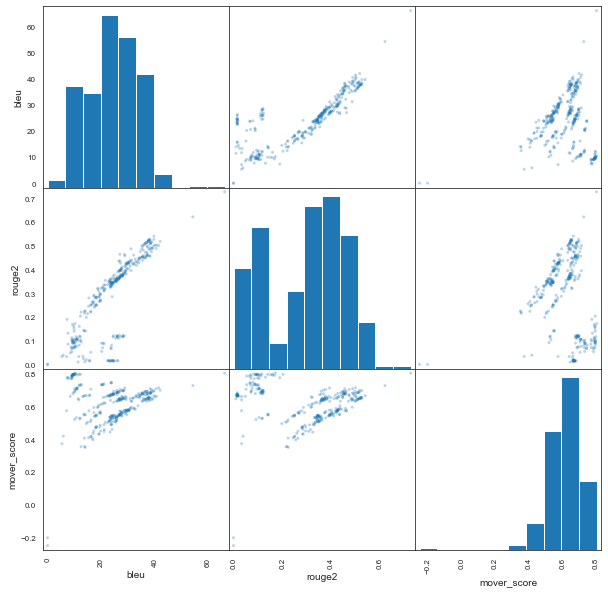

In [4]:
_ = pd.plotting.scatter_matrix(df_wmt[["bleu","rouge2","mover_score"]], alpha=0.3, figsize=(10,10))

Mostly, we see that there's generally a linear-ish correlation between these performance metrics, but we see that there are multiple layers of linear relationships between mover_score vs. metrics. Looks like there's mostly a linear relationship but with some spread. Maybe we can create a strongly correlated subset and less correlated subset.

I picked newstest english-chinese data since it has some spread. To visualize it, we can plot the same scatter matrix of this selection.

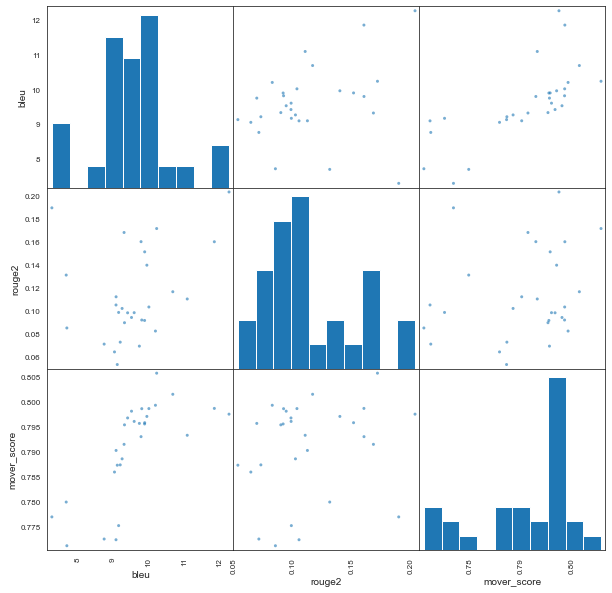

In [5]:
# english-chinese newstest2021 subset
df_enzh = df_wmt[(df_wmt["dataset"] == "newstest2021" )&( df_wmt["langpair"] == "en-zh")]

_ = pd.plotting.scatter_matrix(
                               df_enzh
                               [["bleu","rouge2","mover_score"]], alpha=0.6, figsize=(10,10)
                              )

To capture the generally linear relationships, I'll pick english-german pair for newstest2021 dataset.

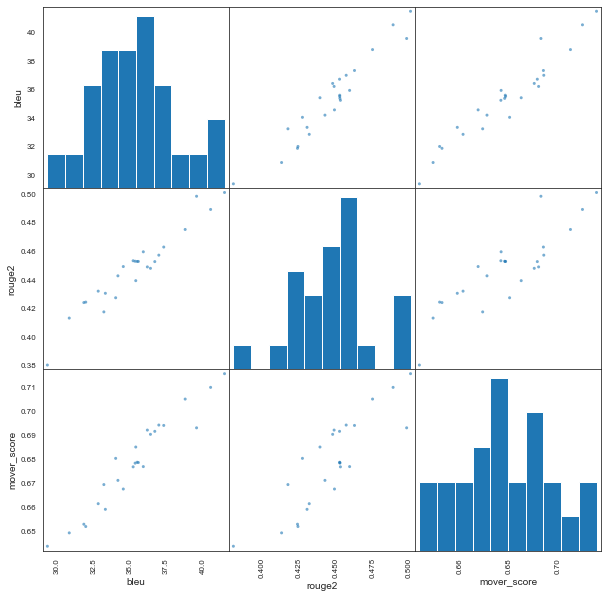

In [6]:
# create a subset of english-german newstest 2021.
df_ende = df_wmt[(df_wmt["dataset"] == "newstest2021" )&( df_wmt["langpair"] == "en-de")]

_ = pd.plotting.scatter_matrix(
                               df_ende
                               [["bleu","rouge2","mover_score"]], alpha=0.6, figsize=(10,10)
                              )

So, generally, I expect to find more correlations in `en-de` set vs. `en-zh` set. Wanted to see what metrics appear correlated in both sets.

# 2. System Performances Per Bucket vs. Overall Performance

What are systems/buckets where one system is much better/worse than expected?

$$
argmax_{b,s} \left| rank_{overall}(s) - rank_{overall}(b, s) \right|
$$


## 2.1 en-zh Dataset

In [7]:
# save the original index from previous dataframe before resetting
df_enzh.index = df_enzh.index.set_names(["original_index"]) 
df_enzh = df_enzh.reset_index()

for metric in ["bleu","rouge2","mover_score"]:
    df_enzh = get_rank_by_metric(df_enzh, metric)

In [8]:
delta_performances = {}

for f in fine_grained_features:
    for m in metrics:
        colname = get_column_name(df_enzh, m, f)
        num_buckets = len(df_enzh[colname].apply(lambda x:x.keys()).max())
        for i in range(num_buckets):
            try:
                if colname not in delta_performances:
                    delta_performances[colname] = {}
                
                delta_performances[colname][i] = np.argmax(delta_expected_perf(df_enzh, m, f, i))
            except:
                print(colname, i)
                

mover_score|mover_score|hypothesis_length 1
bleu|bleu|hypothesis_length 1
rouge2|rouge2|hypothesis_length 1


In [9]:
# performance gaps by buckets
df_delta_performances = pd.DataFrame(delta_performances).T

# label results
df_delta_performances.index = df_delta_performances.index.set_names(["fine_grained_feature"])
df_delta_performances = df_delta_performances.reset_index()
df_delta_performances = df_delta_performances.rename(columns = { i : "bucket_idx_{}".format(i) for i in range(4)})

df_delta_performances

,fine_grained_feature,bucket_idx_0,bucket_idx_1,bucket_idx_2,bucket_idx_3
0,mover_score|mover_score|source_length,8.0,7.0,14.0,6.0
1,bleu|bleu|source_length,11.0,7.0,15.0,9.0
2,rouge2|rouge2|source_length,24.0,7.0,24.0,22.0
3,mover_score|mover_score|reference_length,4.0,13.0,5.0,NaN
4,bleu|bleu|reference_length,15.0,12.0,3.0,NaN
5,rouge2|rouge2|reference_length,26.0,2.0,21.0,NaN
6,mover_score|mover_score|hypothesis_length,9.0,NaN,NaN,NaN
7,bleu|bleu|hypothesis_length,24.0,NaN,NaN,NaN
8,rouge2|rouge2|hypothesis_length,17.0,NaN,NaN,NaN
9,mover_score|mover_score|attr_compression,1.0,6.0,2.0,6.0


In [10]:
# most common performance gap by features
for f in fine_grained_features:
    mask = df_delta_performances["fine_grained_feature"].apply(lambda x: f in x)
    df_f_subset = df_delta_performances[mask]
    print("feature: {}, most common model idx and count: {}\n".format(f, get_mode_model(df_f_subset)))

feature: source_length, most common model idx and count: ModeResult(mode=array([7.]), count=array([3]))

feature: reference_length, most common model idx and count: ModeResult(mode=array([2.]), count=array([1]))

feature: hypothesis_length, most common model idx and count: ModeResult(mode=array([9.]), count=array([1]))

feature: attr_compression, most common model idx and count: ModeResult(mode=array([15.]), count=array([3]))

feature: tok_capitalness, most common model idx and count: ModeResult(mode=array([3.]), count=array([3]))

feature: tok_position, most common model idx and count: ModeResult(mode=array([3.]), count=array([3]))

feature: tok_chars, most common model idx and count: ModeResult(mode=array([24.]), count=array([3]))

feature: tok_test_freq, most common model idx and count: ModeResult(mode=array([3.]), count=array([7]))



In [11]:
# most common model for this performance gap, overall
get_mode_model(df_delta_performances)

ModeResult(mode=array([3.]), count=array([17]))

## 2.2 en-de Dataset

Basically the same thing except for en-de.

In [12]:
# save the original index from previous dataframe before resetting
df_ende.index = df_ende.index.set_names(["original_index"]) 
df_ende = df_ende.reset_index()

for metric in ["bleu","rouge2","mover_score"]:
    df_ende = get_rank_by_metric(df_ende, metric)

In [13]:
delta_performances = {}

for f in fine_grained_features:
    for m in metrics:
        colname = get_column_name(df_ende, m, f)
        num_buckets = len(df_ende[colname].apply(lambda x:x.keys()).max())
        for i in range(num_buckets):
            try:
                if colname not in delta_performances:
                    delta_performances[colname] = {}
                
                delta_performances[colname][i] = np.argmax(delta_expected_perf(df_ende, m, f, i))
            except:
                print(colname, i)

In [14]:
# performance gaps by individual buckets
df_delta_performances = pd.DataFrame(delta_performances).T

## label results clearly
df_delta_performances.index = df_delta_performances.index.set_names(["fine_grained_feature"]) 
df_delta_performances = df_delta_performances.reset_index()
df_delta_performances = df_delta_performances.rename(columns = { i : "bucket_idx_{}".format(i) for i in range(4)})

df_delta_performances

,fine_grained_feature,bucket_idx_0,bucket_idx_1,bucket_idx_2,bucket_idx_3
0,mover_score|mover_score|source_length,8,8,10,12
1,bleu|bleu|source_length,10,17,14,10
2,rouge2|rouge2|source_length,5,14,17,17
3,mover_score|mover_score|reference_length,4,3,15,15
4,bleu|bleu|reference_length,7,17,19,14
5,rouge2|rouge2|reference_length,5,6,14,10
6,mover_score|mover_score|hypothesis_length,8,10,10,11
7,bleu|bleu|hypothesis_length,14,9,19,16
8,rouge2|rouge2|hypothesis_length,10,5,14,17
9,mover_score|mover_score|attr_compression,14,11,11,9


In [15]:
# most common performance gap by features
for f in fine_grained_features:
    mask = df_delta_performances["fine_grained_feature"].apply(lambda x: f in x)
    df_f_subset = df_delta_performances[mask]
    print("feature: {}, most common model idx and count: {}\n".format(f, get_mode_model(df_f_subset)))

feature: source_length, most common model idx and count: ModeResult(mode=array([10]), count=array([3]))

feature: reference_length, most common model idx and count: ModeResult(mode=array([14]), count=array([2]))

feature: hypothesis_length, most common model idx and count: ModeResult(mode=array([10]), count=array([3]))

feature: attr_compression, most common model idx and count: ModeResult(mode=array([14]), count=array([4]))

feature: tok_capitalness, most common model idx and count: ModeResult(mode=array([17]), count=array([3]))

feature: tok_position, most common model idx and count: ModeResult(mode=array([15]), count=array([3]))

feature: tok_chars, most common model idx and count: ModeResult(mode=array([8]), count=array([2]))

feature: tok_test_freq, most common model idx and count: ModeResult(mode=array([15]), count=array([3]))



In [16]:
# most common model for this performance gap, overall
get_mode_model(df_delta_performances)

ModeResult(mode=array([14]), count=array([15]))

# 3. Correlation between Language Features and Bucket performance differentials

What are the features of the language that are correlated with over/under performance on particular phenomena?

$$
\text{argmax}_{b, l} \left| \text{corr} \Bigl( \text{perf}_{bucket}(b,s) - \text{perf}_{overall}, \text{lang_feat}(l) \Bigr)  \right|
$$

where

$b$ = bucket,
$l$ = language, 
$s$ = system

My understanding of that eq: 2 parts.
1. what features of the language $\text{lang_feat}(l)$ is correlated with the performance gap $\Delta \text{perf}$.
2. for what bucket/language? $\text{argmax}_{b, l}$

So, we can take this problem apart into 2 parts too.
1. Kruskal Wallis correlation to figure out which features are correlated, statistically significantly
2. use regression coefficient to figure out what buckets are the more/less important for those features from 1.

## 3.1 en-zh Dataset

In [17]:
delta_performances = {}

for m in metrics:
    for f in fine_grained_features:
        colname = get_column_name(df_enzh, m, f)
        num_buckets = len(df_enzh[colname][0].keys())
        perf_overall = df_enzh[m]
        for i in range(num_buckets):
            try:
                if colname not in delta_performances:
                    delta_performances[colname] = {}
                
                delta_performances[colname][i] = performances_by_bucket(df_enzh, m, f, i) - perf_overall
            except:
                print(colname, i)

mover_score|mover_score|hypothesis_length 1
bleu|bleu|hypothesis_length 1
rouge2|rouge2|hypothesis_length 1


To walk myself through null hypothesis testing;; (I always get this mixed up), I'll pick moverscores bucketed by reference length feature, to see if their correlation with performance gap is statistically significant.

Using Kruskal-Wallis test, I'll calculate the H-value and p-value first. 

In [18]:
ref_len_perfgap = delta_performances["mover_score|mover_score|reference_length"]

stats.kruskal(*[ref_len_perfgap[bucket] for bucket in ref_len_perfgap])

KruskalResult(statistic=76.45454545454544, pvalue=2.500957987881029e-17)

So, the H-value is ~10 and corresponding p-value ~ 3e-17 << 0.05.

Which means that we fail to reject the null hypothesis. 
- Null hypothesis of Kruskal Wallis: mean ranks of the buckets are the same. Or informally, the medians of the buckets are the same.

Which means that `mover_score` bucketed by `reference_length` and the correlation ***IS*** statistically significant.

Now, we do this for all features and metrics.

In [19]:
results = []
print("--++--Statistically Significant Correlations--++--\n\n")

for k in delta_performances.keys():
    try:
        observations = delta_performances[k]
        kruskal_stat = stats.kruskal(*[observations[col] for col in observations])
        
        
        if kruskal_stat[1] < 0.05:
            print("feature: {},\nkruskal results: {}\n".format(k, kruskal_stat))
            results.append((k, kruskal_stat))
    except:
        pass

--++--Statistically Significant Correlations--++--


feature: mover_score|mover_score|source_length,
kruskal results: KruskalResult(statistic=104.5680965883106, pvalue=1.6183081463582155e-22)

feature: mover_score|mover_score|reference_length,
kruskal results: KruskalResult(statistic=76.45454545454544, pvalue=2.500957987881029e-17)

feature: mover_score|mover_score|attr_compression,
kruskal results: KruskalResult(statistic=107.66721546388607, pvalue=3.485956381884009e-23)

feature: mover_score|F1|tok_capitalness,
kruskal results: KruskalResult(statistic=39.000445174883566, pvalue=1.735288327456466e-08)

feature: mover_score|F1|tok_position,
kruskal results: KruskalResult(statistic=15.083345054677546, pvalue=0.0017467923761054834)

feature: mover_score|F1|tok_chars,
kruskal results: KruskalResult(statistic=58.31749811715419, pvalue=1.344683355993861e-12)

feature: bleu|bleu|source_length,
kruskal results: KruskalResult(statistic=103.6283728162444, pvalue=2.5774841441302014e-22)

feature

In [20]:
max(results, key=lambda x:x[1])

('mover_score|mover_score|attr_compression',
 KruskalResult(statistic=107.66721546388607, pvalue=3.485956381884009e-23))

## 3.2 en-de Dataset

In [21]:
delta_performances = {}

for m in metrics:
    for f in fine_grained_features:
        colname = get_column_name(df_ende, m, f)
        num_buckets = len(df_ende[colname][0].keys())
        perf_overall = df_ende[m]
        for i in range(num_buckets):
            try:
                if colname not in delta_performances:
                    delta_performances[colname] = {}
                
                delta_performances[colname][i] = performances_by_bucket(df_ende, m, f, i) - perf_overall
            except:
                print(colname, i)

In [22]:
results = []
print("--++--Statistically Significant Correlations--++--\n\n")

for k in delta_performances.keys():
    try:
        observations = delta_performances[k]
        kruskal_stat = stats.kruskal(*[observations[col] for col in observations])
        
        
        if kruskal_stat[1] < 0.05:
            print("feature: {},\nkruskal results: {}\n".format(k, kruskal_stat))
            results.append((k, kruskal_stat))
    except:
        pass

--++--Statistically Significant Correlations--++--


feature: mover_score|mover_score|source_length,
kruskal results: KruskalResult(statistic=74.08971089108906, pvalue=5.677931342179627e-16)

feature: mover_score|mover_score|reference_length,
kruskal results: KruskalResult(statistic=76.31510495049503, pvalue=1.8932753640536148e-16)

feature: mover_score|mover_score|hypothesis_length,
kruskal results: KruskalResult(statistic=82.46879999999999, pvalue=9.065381390317351e-18)

feature: mover_score|mover_score|attr_compression,
kruskal results: KruskalResult(statistic=80.09332277227725, pvalue=2.9310176463030175e-17)

feature: mover_score|F1|tok_capitalness,
kruskal results: KruskalResult(statistic=60.436800000000005, pvalue=4.741567540178511e-13)

feature: mover_score|F1|tok_position,
kruskal results: KruskalResult(statistic=85.35317227722771, pvalue=2.1794438762875894e-18)

feature: mover_score|F1|tok_chars,
kruskal results: KruskalResult(statistic=92.8217821782178, pvalue=5.4247102660513

In [23]:
max(results, key=lambda x:x[1])

('mover_score|F1|tok_chars',
 KruskalResult(statistic=92.8217821782178, pvalue=5.424710266051395e-20))

## 4.3 Regression to describe relationship between the buckets vs. highly correlated features.

Given these results, I think we can do some regression to find the relationship between the buckets in these correlations.

# 4. Metric vs. Metric

What does it mean when a system performs better/worse for one metric vs. another metric?

$$
\text{argmax}_{o, b \in o} \left| \text{corr} \Bigl( \text{perf}_{bucket}(b,s), \text{perf}_{overall}(o) \Bigr)  \right|
$$

where

$b$ = bleu bucket,
$o$ = mover score
for example.



## 4.1 en-de Dataset

In [24]:
corr_performances = {}

for m1 in metrics:
    for m2 in metrics:
        
        if m1 == m2:
            continue
        
        for f in fine_grained_features:
            colname = get_column_name(df_ende, m1, f)
            num_buckets = len(df_ende[colname][0].keys())
            perf_overall = df_ende[m2]
            for i in range(num_buckets):
                try:
                    if colname not in corr_performances:
                        corr_performances[colname] = {}
                    
                    results = stats.pearsonr(performances_by_bucket(df_ende, m1, f, i),perf_overall)
                    
                    if i in corr_performances[colname]:
                        if results[0] > corr_performances[colname][i][2][0]:
                            corr_performances[colname][i] = (m1, m2, results)
                        
                    else:
                        
                        corr_performances[colname][i] = (m1, m2, results)
                except:
                    print(colname, i)

In [25]:
argmax_corr = {}

for f in corr_performances.keys():
    maxval = max(corr_performances[f].items(), key=lambda x:x[1])
    
    argmax_corr[f] = (maxval[0], maxval[1][1], maxval[1][2])
    


In [26]:
df_corr_results = pd.DataFrame(argmax_corr).T

df_corr_results = df_corr_results.rename(columns={0: "max_bucket", 1:"max_metric", 2:"correlation_values"})

In [27]:
df_corr_results

,max_bucket,max_metric,correlation_values
mover_score|mover_score|source_length,2,bleu,"(0.9626433775245233, 1.5185546251146967e-14)"
mover_score|mover_score|reference_length,2,bleu,"(0.9718067997944346, 6.242526841464558e-16)"
mover_score|mover_score|hypothesis_length,2,bleu,"(0.9650658863813918, 7.107826954498267e-15)"
mover_score|mover_score|attr_compression,0,bleu,"(0.9512327024881431, 3.0781854479921844e-13)"
mover_score|F1|tok_capitalness,3,rouge2,"(0.2128554378785568, 0.3069903499416889)"
mover_score|F1|tok_position,1,rouge2,"(0.9837628962216234, 1.1611035462232594e-18)"
mover_score|F1|tok_chars,2,bleu,"(0.9882075333514616, 2.9981681239718264e-20)"
mover_score|F1|tok_test_freq,3,rouge2,"(0.9571442081196526, 7.170910625821807e-14)"
bleu|bleu|source_length,2,rouge2,"(0.9644375927845326, 8.698110699393514e-15)"
bleu|bleu|reference_length,2,rouge2,"(0.9712801588363211, 7.703268923700867e-16)"


In [28]:
for m in metrics:

    mask = df_corr_results.index.str.contains("^{}".format(m))
    print("{}, most correlated metric results:".format(m))
    print(df_corr_results[mask]["max_metric"].mode())
    print("\n\n")

mover_score, most correlated metric results:
0    bleu
Name: max_metric, dtype: object



bleu, most correlated metric results:
0    rouge2
Name: max_metric, dtype: object



rouge2, most correlated metric results:
0    bleu
Name: max_metric, dtype: object





## 4.2 en-zh Dataset

In [29]:
corr_performances = {}

for m1 in metrics:
    
    for m2 in metrics:
        
        if m1 == m2:
            continue
        
        for f in fine_grained_features:
            colname = get_column_name(df_enzh, m1, f)
            num_buckets = len(df_enzh[colname][0].keys())
            perf_overall = df_enzh[m2]
            for i in range(num_buckets):
                try:
                    if colname not in corr_performances:
                        corr_performances[colname] = {}
                    
                    results = stats.pearsonr(performances_by_bucket(df_enzh, m1, f, i),perf_overall)
                    
                    if i in corr_performances[colname]:
                        if results[0] > corr_performances[colname][i][2][0]:
                            corr_performances[colname][i] = (m1, m2, results)
                        
                    else:
                        
                        corr_performances[colname][i] = (m1, m2, results)
                except:
                    print(colname, i)

mover_score|mover_score|hypothesis_length 1
mover_score|mover_score|hypothesis_length 1
bleu|bleu|hypothesis_length 1
bleu|bleu|hypothesis_length 1
rouge2|rouge2|hypothesis_length 1
rouge2|rouge2|hypothesis_length 1


In [30]:
argmax_corr = {}

for f in corr_performances.keys():
    maxval = max(corr_performances[f].items(), key=lambda x:x[1])
    
    argmax_corr[f] = (maxval[0], maxval[1][1], maxval[1][2])
    


In [31]:
df_corr_results = pd.DataFrame(argmax_corr).T

df_corr_results = df_corr_results.rename(columns={0: "max_bucket", 1:"max_metric", 2:"correlation_values"})

In [32]:
df_corr_results

,max_bucket,max_metric,correlation_values
mover_score|mover_score|source_length,0,bleu,"(0.7056350730151001, 1.9056449683600685e-05)"
mover_score|mover_score|reference_length,2,rouge2,"(0.6658796449415656, 8.063410735377946e-05)"
mover_score|mover_score|hypothesis_length,0,bleu,"(0.8322765578494398, 2.1774146404064736e-08)"
mover_score|mover_score|attr_compression,0,rouge2,"(0.6251754890580485, 0.00028781154543478513)"
mover_score|F1|tok_capitalness,2,bleu,"(0.5760832773668089, 0.0010739897690411075)"
mover_score|F1|tok_position,1,bleu,"(0.6567218647552795, 0.0001091318050272196)"
mover_score|F1|tok_chars,0,bleu,"(0.6475773252172108, 0.00014618627729122348)"
mover_score|F1|tok_test_freq,0,bleu,"(0.5444513543429519, 0.0022619985577084223)"
bleu|bleu|source_length,3,mover_score,"(0.8041519588451159, 1.4778942247115673e-07)"
bleu|bleu|reference_length,2,rouge2,"(0.3999167279688127, 0.03159481436887382)"


In [33]:
for m in metrics:

    mask = df_corr_results.index.str.contains("^{}".format(m))
    print("{}, most correlated metric results:".format(m))
    print(df_corr_results[mask]["max_metric"].mode())
    print("\n\n")

mover_score, most correlated metric results:
0    bleu
Name: max_metric, dtype: object



bleu, most correlated metric results:
0    rouge2
Name: max_metric, dtype: object



rouge2, most correlated metric results:
0           bleu
1    mover_score
Name: max_metric, dtype: object





metric correlations look pretty similar for both sets, which makes sense.